# Detect Ads in radio stream using the trained models:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.cluster import MiniBatchKMeans
import joblib
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.callbacks import ModelCheckpoint
from DataGenerator import DataGenerator_Sup
from utility_functions import create_model, create_CNN_model, audio2features_vectors, listen_to, moving_average

Using TensorFlow backend.


Get a list of all files:

In [2]:
Radio_stream_folder = '../Data/radio_streams/' # audio files location

example_files = []
for r,d,f in os.walk(Radio_stream_folder):
    for filename in f:
        if '.mp3' in filename:
            example_files.append(os.path.join(r,filename))

How many mp3 files do we have?

In [3]:
n_files = len(example_files)

print('We have ' + str(n_files) + ' radio streaming examples')

We have 7 radio streaming examples


### Define utility functions:

In [4]:
def extract_timeframe_data(X, start_time, end_time, d=3):
    '''Returns the part of X which is in the defined timeframe'''
    t = np.arange(X.shape[0])*d/60.0 # create time axis
    S_idx = np.argmin((t-start_time)**2) # start index
    E_idx = np.argmin((t-end_time)**2) # end index
#     import pdb;pdb.set_trace()
    return X[S_idx:E_idx]

In [5]:
def get_timestamps(Ad_prob, T=0.85, d=3):
    '''Takes an Ad probability vector, a threshold and time bin size
       and returns start and end timestamps'''
    # smoothing and creating a time axis
    Ad_prob_smooth = moving_average(Ad_prob) # smoothing 
    t = np.arange(len(Ad_prob))*d/60.0 # create time axis
    t_smooth = moving_average(t)
    
    # thresholding for detection and extracting start and end times
    detection_domains = (Ad_prob_smooth>T).astype(int) # get 1s for every detection
    transitions = np.diff(detection_domains) # get transitions between ads and non ads
    
    start_times = t_smooth[:-1][transitions == 1] # ad starts when prob. goes 0 -> 1
    end_times = t_smooth[:-1][transitions == -1] # ad ends when prob. goes 1 -> 0
    
    # if the first event is an end - add a start event at time 0
    if np.min(end_times) < np.min(start_times):
        start_times = np.hstack([0,start_times])
    # if the last event is a start - add an end event at the end of the audio
    if np.max(end_times) < np.max(start_times):
        end_times = np.hstack([end_times, t_smooth[-1]])
    
    timestamps = np.vstack([start_times, end_times]).transpose()
    
    # compute probabilities based on music vs ad classifier
    music_vs_ads_probs =[]
    for i in range(timestamps.shape[0]):
        S_idx = np.argmin((t-timestamps[i][0])**2) # start index
        E_idx = np.argmin((t-timestamps[i][1])**2) # end index
        prob = np.mean(Ad_prob[S_idx:E_idx])
        music_vs_ads_probs.append(prob)
        
    return timestamps, np.vstack(music_vs_ads_probs)

In [6]:
def filter_nonads_speech(X, timestamps, T=0.5):
    '''Returns timestamps vector after filtering speech audio clips 
       which do not contain ads'''
    results = [] # allocate space for results
    
    # choose model's weights
    weights_path = 'models/weights_LeNet5ish_1000_only_podcasts_and_ads_6epochs.hdf5'
    # recreate a model for evaluation
    speech_model = create_CNN_model(quiet = True)
    # load weights
    speech_model.load_weights(weights_path)
    # compile
    speech_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    for i in range(timestamps.shape[0]):
        X_p = extract_timeframe_data(X, *timestamps[i])
        Ad_prob = speech_model.predict(X_p)
        # keep only time frames with ad probability higher than T
        if np.mean(Ad_prob) > T:
            results.append(timestamps[i])
    
    return np.array(results)

In [7]:
def Ad_vs_speech_classifier(X, timestamps, probs):
    '''Returns ad probability vector after applying ad vs speech classification'''
    results = [] # allocate space for results
    
    # choose model's weights
    weights_path = 'models/weights_LeNet5ish_1000_only_podcasts_and_ads_9epochs.hdf5'
    # recreate a model for evaluation
    speech_model = create_CNN_model(quiet = True)
    # load weights
    speech_model.load_weights(weights_path)
    # compile
    speech_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    for i in range(timestamps.shape[0]):
        X_p = extract_timeframe_data(X, *timestamps[i])
        Ad_prob = speech_model.predict(X_p)
        probs[i] = probs[i] * np.mean(Ad_prob)
        
    return probs

### Choose audio file and load it:

In [8]:
n = 6 # file number to load
d = 3 # duration in sec of a sigle clip


In [9]:
example_files[n]

'../Data/radio_streams/Z100 Stream Recording.mp3'

### Run model on file and extract start and end time:

In [10]:
X_cnn = audio2features_vectors(example_files[n], CNN= True)
print(X_cnn.shape)
print('file lenght is ' + str(X_cnn.shape[0]*d/60.0) + ' minutes')

(201, 13, 130, 1)
file lenght is 10.05 minutes


In [12]:
# choose model's weights
weights_path = 'models/weights_LeNet5ish_1000_only_music_and_ads_10epochs.hdf5'

# recreate a model for evaluation
eval_model = create_CNN_model()
# load weights
eval_model.load_weights(weights_path)
# compile
eval_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 130, 16)       160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 130, 16)       2320      
_________________________________________________________________
flatten_1 (Flatten)          (None, 27040)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                865312    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 867,825
Trainable params: 867,825
Non-trainable params: 0
_________________________________________________________________


In [13]:
Ad_prob_cnn = eval_model.predict(X_cnn)
Ad_prob_avg_cnn = moving_average(Ad_prob_cnn)
t = np.arange(len(Ad_prob_cnn))*d/60.0 # create time axis
t_avg = moving_average(t)

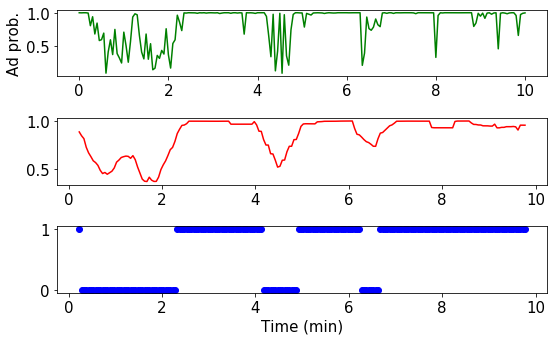

In [14]:
# %matplotlib notebook
T = 0.85

plt.rcParams.update({'font.size': 15})
plt.figure(figsize= (8,5))
plt.subplot(3,1,1)
plt.plot(t, Ad_prob_cnn, 'g')
plt.ylabel('Ad prob.')

plt.subplot(3,1,2)
plt.plot(t_avg, Ad_prob_avg_cnn, 'r')

plt.subplot(3,1,3)
plt.plot(t_avg, Ad_prob_avg_cnn>T, 'bo')
plt.xlabel('Time (min)')
plt.tight_layout()

In [15]:
timestamps, probs = get_timestamps(Ad_prob_cnn)
print(timestamps)
print(probs)

[[0.    0.225]
 [2.275 4.125]
 [4.875 6.225]
 [6.625 9.775]]
[[0.9993076]
 [0.978228 ]
 [0.9875266]
 [0.959395 ]]


In [ ]:
k = 1
listen_to(example_files[n], timestamps[k][0], timestamps[k][1])

### Second step: Ads vs. speech

Find the probability of each timeframe being an ad:

In [16]:
Ad_vs_speech_classifier(X_cnn, *get_timestamps(Ad_prob_cnn))

array([[0.7052678],
       [0.5576114],
       [0.7725153],
       [0.7048328]], dtype=float32)

Filter only high probability time frames:

In [17]:
filter_nonads_speech(X_cnn, timestamps)

array([[0.   , 0.225],
       [4.875, 6.225],
       [6.625, 9.775]])

### Debuging and testing:

In [ ]:
X_p = extract_timeframe_data(X_cnn, *timestamps[1])

In [ ]:
X_p.shape

In [ ]:
# choose model's weights
weights_path = 'models/weights_LeNet5ish_1000_only_podcasts_and_ads_6epochs.hdf5'

# recreate a model for evaluation
speech_model = create_CNN_model(quiet=True)
# load weights
speech_model.load_weights(weights_path)
# compile
speech_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
if 1:
    Ad_prob = speech_model.predict(X_p)
    Ad_prob_avg = moving_average(Ad_prob)
    tp = np.arange(len(Ad_prob))*d/60.0 # create time axis
    tp_avg = moving_average(t)

In [ ]:
if 1:
    %matplotlib notebook
    T = 0.85

    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize= (6,3))
    plt.plot(tp, Ad_prob, 'g')
    plt.ylabel('Ad prob.')

In [ ]:
Ad_prob = speech_model.predict(X_p)
Ad_prob

In [ ]:
np.mean(Ad_prob)